In [30]:
import numpy as np
import librosa
from pathlib import Path
import pickle
import json
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import os
from pydub import AudioSegment
from pydub.playback import play
from IPython.display import Audio, display



def load_audio(file_path, sr=22050):
    """
    Load an audio file using librosa.

    Parameters:
    file_path (str): Path to the audio file.
    sr (int): Sampling rate for loading the audio. Default is 22050 Hz.

    Returns:
    tuple: (audio time series, sampling rate)
    """
    y, sr = librosa.load(file_path, sr=sr)
    return y, sr

def extract_features(y, sr):
    """
    Extract features from an audio time series.

    Parameters:
    y (numpy.ndarray): Audio time series.
    sr (int): Sampling rate of the audio.

    Returns:
    dict: Extracted features including MFCCs, chroma, spectral contrast, and zero-crossing rate.
    """
    # Extract MFCC features
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    # Extract Chroma features
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    # Extract Spectral Contrast features
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    # Extract Zero Crossing Rate
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y=y)
    
    return {
        'mfccs': mfccs,
        'chroma': chroma,
        'spectral_contrast': spectral_contrast,
        'zero_crossing_rate': zero_crossing_rate
    }

def process_audio_directory(directory_path, output_file='./extracted_features.pkl'):
    """
    Process all audio files in a directory to extract features and save them to a pickle file.

    Parameters:
    directory_path (str): Path to the directory containing audio files.
    output_file (str): Path to the pickle file where features will be saved.

    Returns:
    list: List of dictionaries containing features for each file.
    """
    directory = Path(directory_path)
    features_list = []
    for file_path in directory.glob('*.mp3'):
        y, sr = load_audio(str(file_path))
        features = extract_features(y, sr)
        features_list.append({'file_name': file_path.name, 'features': features})
    
    # Write features to a pickle file
    with open(output_file, 'wb') as f:
        pickle.dump(features_list, f)
    
    return features_list

def load_audio_features(pickle_file):
    """
    Load audio features from a pickle file.

    Parameters:
    pickle_file (str): Path to the pickle file containing audio features.

    Returns:
    list: List of dictionaries containing features for each file.
    """
    with open(pickle_file, 'rb') as f:
        features_list = pickle.load(f)
    return features_list

def prepare_features_for_clustering(features_list):
    """
    Prepare features for clustering by converting them into a suitable format.

    Parameters:
    features_list (list): List of dictionaries containing features for each file.

    Returns:
    numpy.ndarray: A 2D array where each row represents concatenated features of an audio file.
    """
    feature_vectors = []
    for item in features_list:
        features = item['features']
        # Flatten and concatenate features
        feature_vector = np.concatenate([
            np.mean(features['mfccs'], axis=1),
            np.mean(features['chroma'], axis=1),
            np.mean(features['spectral_contrast'], axis=1),
            np.mean(features['zero_crossing_rate'], axis=1)
        ])
        feature_vectors.append(feature_vector)
    return np.array(feature_vectors)

def cluster_features_hierarchical(feature_vectors, n_clusters=4):
    """
    Cluster the feature vectors using Agglomerative Clustering and plot a dendrogram.

    Parameters:
    feature_vectors (numpy.ndarray): A 2D array where each row represents features of an audio file.
    n_clusters (int): The number of clusters to form. Default is 4.

    Returns:
    numpy.ndarray: Array of cluster labels for each feature vector.
    """
    # Perform hierarchical clustering
    clustering = AgglomerativeClustering(n_clusters=n_clusters)
    labels = clustering.fit_predict(feature_vectors)
    
    # Plot dendrogram
    linkage_matrix = sch.linkage(feature_vectors, method='ward')
    plt.figure(figsize=(10, 7))
    sch.dendrogram(linkage_matrix)
    plt.title("Dendrogram for Hierarchical Clustering")
    plt.xlabel("Audio Files")
    plt.ylabel("Distance")
    plt.show()
    
    return labels

def load_ground_truth_labels(json_file):
    """
    Load ground truth labels from a JSON file.

    Parameters:
    json_file (str): Path to the JSON file containing ground truth labels.

    Returns:
    dict: Dictionary containing file names as keys and labels as values.
    """
    with open(json_file, 'r') as f:
        ground_truth = json.load(f)
    return ground_truth

def label_clusters(features_list, cluster_labels, ground_truth, n_samples=10, file_path='./path_to_your_audio_files'):
    """
    Label clusters using ground truth data and manual labeling if needed.

    Parameters:
    features_list (list): List of dictionaries containing features for each file.
    cluster_labels (numpy.ndarray): Array of cluster labels for each feature vector.
    ground_truth (dict): Dictionary containing ground truth labels.
    n_samples (int): Number of manual samples to label.
    file_path (str): Path to the directory containing audio files.

    Returns:
    dict: Dictionary containing cluster labels as keys and assigned tags as values.
    """
    cluster_to_label = {}
    labeled_files = 0
    
    for idx, item in enumerate(features_list):
        file_name = item['file_name']
        cluster_id = cluster_labels[idx]
        
        # Assign label using ground truth if available
        if file_name in ground_truth:
            label = ground_truth[file_name]
            cluster_to_label[cluster_id] = label
        elif isinstance(n_samples, int) and labeled_files < n_samples:
            # Manually label remaining samples if needed
            print(f"File: {file_name}, Cluster: {cluster_id}")
            mp3_file = Path(file_path) / file_name
            # Load and play the audio in Jupyter
            display(Audio(str(mp3_file), autoplay=True))
            label = input("Enter label (Music, Dialogue, Both, None): ")
            cluster_to_label[cluster_id] = label
            labeled_files += 1
    
    return cluster_to_label

def create_m3u_playlists(features_list, cluster_labels, cluster_to_label, directory_path):
    """
    Create M3U playlists for audio files based on their assigned labels.

    Parameters:
    features_list (list): List of dictionaries containing features for each file.
    cluster_labels (numpy.ndarray): Array of cluster labels for each feature vector.
    cluster_to_label (dict): Dictionary containing cluster labels and their assigned tags.
    directory_path (str): Path to the directory containing audio files.
    """
    # Create a playlist file for each label
    labels = set(cluster_to_label.values())
    for label in labels:
        playlist_path = Path(directory_path) / f"{label}.m3u"
        with open(playlist_path, 'w') as playlist_file:
            for idx, item in enumerate(features_list):
                file_name = item['file_name']
                cluster_id = cluster_labels[idx]
                if cluster_id in cluster_to_label and cluster_to_label[cluster_id] == label:
                    playlist_file.write(f"{directory_path}/{file_name}\n")


In [24]:
directory_path = './TRAINING_DATA/PREPARED/outro/'
audio_features = process_audio_directory(directory_path)


directory_path = "./TRAINING_DATA/PREPARED/outro/"
output_file = "./audio_features.pkl"
# audio_features = process_audio_directory(directory_path, output_file)
# print(audio_features)


# Load features from pickle file
loaded_features = load_audio_features(output_file)
feature_vectors = prepare_features_for_clustering(loaded_features)

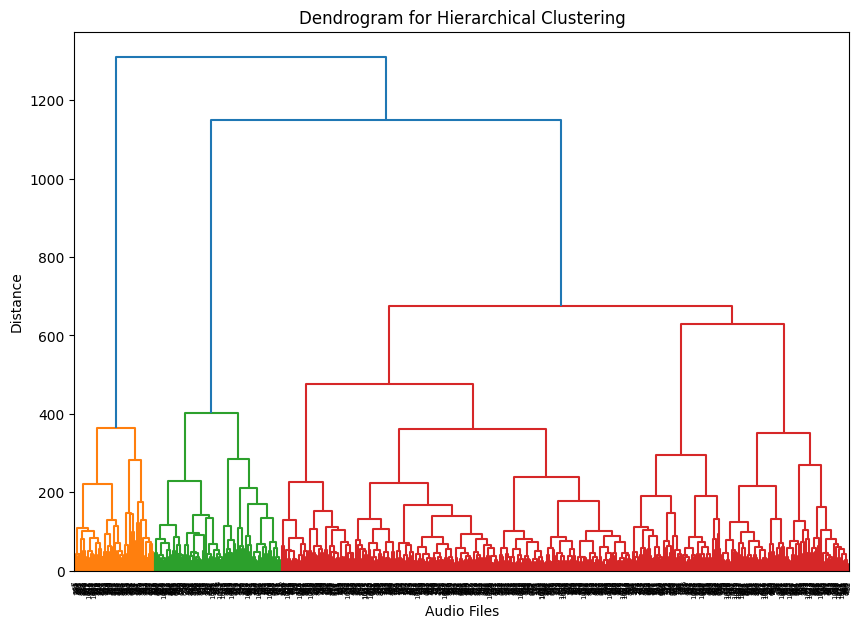

In [4]:
# Perform clustering
cluster_labels = cluster_features_hierarchical(feature_vectors)

In [15]:
# load ground truth, manually tagged files
ground_truth = load_ground_truth_labels('track_classifications.json')

# cluster_to_label = label_clusters(loaded_features, cluster_labels, ground_truth, directory_path)
cluster_to_label = label_clusters(features_list=loaded_features, 
                                  cluster_labels=cluster_labels, 
                                  ground_truth=ground_truth,
                                  n_samples=25,
                                  file_path=directory_path)

File: 014-20241015_me_tensions_between_canada_and_india_have_escalated_dramatically_chunk_1.mp3, Cluster: 1


Enter label (Music, Dialogue, Both, None):  Dialogue


File: 005-20240930_atc_when_vp_debates_make_a_difference_chunk_1.mp3, Cluster: 1


Enter label (Music, Dialogue, Both, None):  Dialogue


File: 016-20241008_me_thanks_to_a_canadian_streaming_service_dallas_nhl_fans_can_watch_stars_games_chunk_1.mp3, Cluster: 2


Enter label (Music, Dialogue, Both, None):  Both


File: 003-20241006_wesun_a_volunteer_recovery_effort_is_underway_to_reach_isolated_communities_in_north_carolina_chunk_1.mp3, Cluster: 3


Enter label (Music, Dialogue, Both, None):  Both


File: 005-20241014_atc_d.c._birdwatchers_remember_the_land_s_history_on_indigenous_people_s_day_chunk_1.mp3, Cluster: 0


Enter label (Music, Dialogue, Both, None):  Music


File: 009-20241008_me_singing_teacher_in_kansas_helps_students_work_toward_their_musical_theater_dreams_chunk_1.mp3, Cluster: 1


Enter label (Music, Dialogue, Both, None):  Both


File: 005-20241009_atc_remembering_hurricane_charley_chunk_1.mp3, Cluster: 0


Enter label (Music, Dialogue, Both, None):  Both


File: 015-20240929_wesun_trump_and_walz_take_politics_to_the_football_field_with_respective_visits_chunk_1.mp3, Cluster: 1


Enter label (Music, Dialogue, Both, None):  Both


File: 012-20241001_me_the_shortcomings_of_china_s_1-party_rule_mistakes_missed_opportunities_chunk_1.mp3, Cluster: 1


Enter label (Music, Dialogue, Both, None):  Dialogue


File: 003-20241001_atc_vance_and_walz_face_off_in_nyc_chunk_1.mp3, Cluster: 1


Enter label (Music, Dialogue, Both, None):  Both


File: 003-20241025_me_trump_military_plans_chunk_1.mp3, Cluster: 0


Enter label (Music, Dialogue, Both, None):  Both


File: 002-20241018_me_gaza_latest_chunk_1.mp3, Cluster: 1


Enter label (Music, Dialogue, Both, None):  Dialogue


File: 005-20241007_atc_brain_science_s_new_direction_chunk_1.mp3, Cluster: 3


Enter label (Music, Dialogue, Both, None):  Both


File: 010-20241011_atc_waymo_waymos_chunk_1.mp3, Cluster: 3


Enter label (Music, Dialogue, Both, None):  Music


File: 012-20241001_atc_ina_garten_of_barefoot_contessa_reflects_on_life_and_career_in_new_memoir_chunk_1.mp3, Cluster: 0


Enter label (Music, Dialogue, Both, None):  Music


File: 009-20241022_me_wall_street_journal_covers_presidential_election_with_economy_geopolitics_in_mind_chunk_1.mp3, Cluster: 2


Enter label (Music, Dialogue, Both, None):  Both


File: 015-20241002_atc_judge_unseals_new_trump_jan._6_election_interference_evidence_chunk_1.mp3, Cluster: 1


Enter label (Music, Dialogue, Both, None):  Dialogue


File: 009-20241007_me_an_immigrant_street_vendor_in_queens_n.y._is_forced_to_confront_crippling_shyness_chunk_1.mp3, Cluster: 0


Enter label (Music, Dialogue, Both, None):  Both


File: 011-20241015_atc_republican_outreach_for_harris_chunk_1.mp3, Cluster: 1


Enter label (Music, Dialogue, Both, None):  Dialogue


File: 002-20241025_me_harris_in_houston_chunk_1.mp3, Cluster: 1


Enter label (Music, Dialogue, Both, None):  Dialogue


File: 014-20240927_atc_gps_back-up_atc_chunk_1.mp3, Cluster: 1


Enter label (Music, Dialogue, Both, None):  Dialogue


File: 004-20241007_atc_politics_weekahead_chunk_1.mp3, Cluster: 1


Enter label (Music, Dialogue, Both, None):  Dialogue


File: 012-20240922_wesun_the_human_cost_of_ghost_networks_chunk_1.mp3, Cluster: 1


Enter label (Music, Dialogue, Both, None):  Dialogue


File: 002-20240922_wesun_shooting_in_birmingham_ala._leaves_at_least_4_dead_dozens_injured_chunk_1.mp3, Cluster: 1


Enter label (Music, Dialogue, Both, None):  Dialogue


File: 008-20240927_atc_huge_explosions_rocked_beirut_as_israel_says_it_was_targeting_hezbollah_headquarters_chunk_1.mp3, Cluster: 1


Enter label (Music, Dialogue, Both, None):  Dialogue


In [27]:
# save current clusters to m3u files for checking
create_m3u_playlists(loaded_features, cluster_labels, cluster_to_label, './')